In [1]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))


#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

#If we want to avoid zero-padding, then the input seq len will be determined
# by parameters of the convolutions
class AbstractProfileModel(object):
    
    def get_output_profile_len(self):
        raise NotImplementedError()
  
    def get_model(self):
        raise NotImplementedError()
  
def trim_flanks_of_conv_layer(conv_layer, output_len, width_to_trim, filters):
    layer = keras.layers.Lambda(
        lambda x: x[:,
          int(0.5*(width_to_trim)):-(width_to_trim-int(0.5*(width_to_trim)))],
        output_shape=(output_len, filters))(conv_layer)
    return layer
        
#model architecture is based on 
#https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/models.py#L534
#The non-cli parameters are specified in:
# https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/src/chipnexus/train/seqmodel/joint-model-valid.gin
#The cli parameters are in line 165 of:
# https://docs.google.com/spreadsheets/d/1n3l2HXKSNpmNUOifD41uRzDEAgmOqXMQDxquRaz6WLg/edit#gid=0
# which seems to match https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/src/chipnexus/train/seqmodel/ChIP-seq-default.gin
class RcBPnetArch(AbstractProfileModel):   

    def __init__(self, input_seq_len, c_task_weight, filters,
                       n_dil_layers, conv1_kernel_size,
                       dil_kernel_size,
                       outconv_kernel_size, lr):
        self.input_seq_len = input_seq_len
        self.c_task_weight = c_task_weight
        self.filters = filters
        self.n_dil_layers = n_dil_layers
        self.conv1_kernel_size = conv1_kernel_size
        self.dil_kernel_size = dil_kernel_size
        self.outconv_kernel_size = outconv_kernel_size
        self.lr = lr
    
    def get_embedding_len(self):
        embedding_len = self.input_seq_len
        embedding_len -= (self.conv1_kernel_size-1)     
        for i in range(1, self.n_dil_layers+1):
            dilation_rate = (2**i)
            embedding_len -= dilation_rate*(self.dil_kernel_size-1)
        return embedding_len
    
    def get_output_profile_len(self):
        embedding_len = self.get_embedding_len()
        out_profile_len = embedding_len - (self.outconv_kernel_size - 1)
        return out_profile_len
    
    def get_keras_model(self):
      
        out_pred_len = self.get_output_profile_len()
        
        inp = kl.Input(shape=(self.input_seq_len, 4), name='sequence')
        first_conv = RevCompConv1D(filters=self.filters,
                               kernel_size=self.conv1_kernel_size,
                               padding='valid',
                               activation='relu')(inp)
        curr_layer_size = self.input_seq_len - (self.conv1_kernel_size-1)
        prev_layers = [first_conv]
        for i in range(1, self.n_dil_layers + 1):
          dilation_rate = 2**i
          if i == 1:
              prev_sum = first_conv
          else:
              print(prev_layers)
              prev_sum = kl.merge.Average()(prev_layers)
          conv_output = RevCompConv1D(filters=self.filters,
                                  kernel_size=self.dil_kernel_size,
                                  padding='valid',
                                  activation='relu',
                                  dilation_rate=dilation_rate)(prev_sum)          
          width_to_trim = dilation_rate*(self.dil_kernel_size-1)
          curr_layer_size = (curr_layer_size - width_to_trim)
          prev_layers = [trim_flanks_of_conv_layer(
              conv_layer=x, output_len=curr_layer_size,
              width_to_trim=width_to_trim, filters=2*self.filters)
              for x in prev_layers]
          prev_layers.append(conv_output)

        combined_conv = kl.merge.Average()(prev_layers)

        #Counts prediction
        gap_combined_conv = kl.GlobalAvgPool1D()(combined_conv)
        count_out = kl.Reshape((-1,), name="task0_logcount")(
            RevCompConv1D(filters=1, kernel_size=1)(
              kl.Reshape((1,-1))(gap_combined_conv)))
#                   kl.concatenate([
#                   #concatenation of the bias layer both before and after
#                   # is needed for rc symmetry
#                   kl.Lambda(lambda x: x[:, ::-1])(bias_counts_input),
#                   gap_combined_conv,
#                   bias_counts_input], axis=-1))))

        profile_out_prebias = RevCompConv1D(
                               filters=1,
                               kernel_size=self.outconv_kernel_size,
                               padding='valid')(combined_conv)
        profile_out = RevCompConv1D(
            filters=1, kernel_size=1, name="task0_profile")(profile_out_prebias)
#                     kl.concatenate([
#                         #concatenation of the bias layer both before and after
#                         # is needed for rc symmetry
#                         kl.Lambda(lambda x: x[:, :, ::-1])(bias_profile_input),
#                         profile_out_prebias,
#                         bias_profile_input], axis=-1))

        model = keras.models.Model(
          inputs=[inp],
          outputs=[count_out, profile_out])
        model.compile(keras.optimizers.Adam(lr=self.lr),
                      loss=['mse', MultichannelMultinomialNLL(2)],
                      loss_weights=[self.c_task_weight, 1])
        return model

seq_len = 1346

modelwrapper = RcBPnetArch(
    input_seq_len=seq_len, c_task_weight=100,
    filters=64, n_dil_layers=6,
    conv1_kernel_size=21,
    dil_kernel_size=3,
    outconv_kernel_size=75,
    lr=0.001)
out_pred_len = modelwrapper.get_output_profile_len()
print(out_pred_len, seq_len-out_pred_len)

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

1000 346


In [2]:
inputs_coordstovals = coordstovals.core.CoordsToValsJoiner(
    coordstovals_list=[
      coordbased.coordstovals.fasta.PyfaidxCoordsToVals(
        genome_fasta_path="/users/amr1/pho4/data/a5/tseries/hg38.genome.fa",
        mode_name="sequence",
        center_size_to_use=seq_len)])

targets_coordstovals = coordstovals.bigwig.PosAndNegSeparateLogCounts(
    pos_strand_bigwig_path="/users/amr1/pho4/data/a5/tseries/2hr/pos_strand.bw",
    neg_strand_bigwig_path="/users/amr1/pho4/data/a5/tseries/2hr/neg_strand.bw",
    counts_mode_name="task0_logcount",
    profile_mode_name="task0_profile",
    center_size_to_use=out_pred_len)

# def qc_func(inputs, targets):
#     return (np.where(np.logical_and(targets['task0_logcount'][:,0] >= 2,
#                                     targets['task0_logcount'][:,1] >= 2)))

keras_train_batch_generator = coordbased.core.KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
      bed_file="/users/amr1/pho4/data/a5/tseries/2hr/train_1000_around_summits.bed.gz",
      coord_batch_transformer=
          coordbatchtransformers.UniformJitter(
              maxshift=200, chromsizes_file="/users/amr1/pho4/data/a5/tseries/hg38.chrom.sizes"),
      batch_size=128,
      shuffle_before_epoch=True, 
      seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals)#,qc_func=qc_func)

keras_valid_batch_generator = coordbased.core.KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
            bed_file="/users/amr1/pho4/data/a5/tseries/2hr/valid_1000_around_summits.bed.gz",
            batch_size=128,
            shuffle_before_epoch=False, 
            seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals)#,qc_func=qc_func)

thebatch = keras_train_batch_generator[0]
for tupleidx,tupleentry in enumerate(thebatch):
  print("Tuple entry",tupleidx)
  for key in tupleentry:
    print(key, tupleentry[key].shape)

Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
Tuple entry 0
sequence (128, 1346, 4)
Tuple entry 1
task0_logcount (128, 2)
task0_profile (128, 1000, 2)


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"    

model = modelwrapper.get_keras_model()
print(model.summary())
early_stopping_callback = keras.callbacks.EarlyStopping(
                            patience=10, restore_best_weights=True)
loss_history = model.fit_generator(keras_train_batch_generator,
                    epochs=200,
                    validation_data=keras_valid_batch_generator,
                    callbacks=[early_stopping_callback])
model.set_weights(early_stopping_callback.best_weights)




[<tf.Tensor 'lambda_1/strided_slice:0' shape=(?, 1322, 128) dtype=float32>, <tf.Tensor 'rev_comp_conv1d_2/Relu:0' shape=(?, 1322, 128) dtype=float32>]
[<tf.Tensor 'lambda_2/strided_slice:0' shape=(?, 1314, 128) dtype=float32>, <tf.Tensor 'lambda_3/strided_slice:0' shape=(?, 1314, 128) dtype=float32>, <tf.Tensor 'rev_comp_conv1d_3/Relu:0' shape=(?, 1314, 128) dtype=float32>]
[<tf.Tensor 'lambda_4/strided_slice:0' shape=(?, 1298, 128) dtype=float32>, <tf.Tensor 'lambda_5/strided_slice:0' shape=(?, 1298, 128) dtype=float32>, <tf.Tensor 'lambda_6/strided_slice:0' shape=(?, 1298, 128) dtype=float32>, <tf.Tensor 'rev_comp_conv1d_4/Relu:0' shape=(?, 1298, 128) dtype=float32>]
[<tf.Tensor 'lambda_7/strided_slice:0' shape=(?, 1266, 128) dtype=float32>, <tf.Tensor 'lambda_8/strided_slice:0' shape=(?, 1266, 128) dtype=float32>, <tf.Tensor 'lambda_9/strided_slice:0' shape=(?, 1266, 128) dtype=float32>, <tf.Tensor 'lambda_10/strided_slice:0' shape=(?, 1266, 128) dtype=float32>, <tf.Tensor 'rev_c

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.856878). Check your callbacks.
  % delta_t_median)


  2/113 [..............................] - ETA: 1:47 - loss: 549.9055 - task0_logcount_loss: 0.5099 - task0_profile_loss: 498.9162

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.439693). Check your callbacks.
  % delta_t_median)


113/113 [==============================] - 32s 280ms/step - loss: 559.7994 - task0_logcount_loss: 0.5169 - task0_profile_loss: 508.1053 - val_loss: 499.2190 - val_task0_logcount_loss: 0.4633 - val_task0_profile_loss: 452.8866
Epoch 11/200
113/113 [==============================] - 29s 256ms/step - loss: 559.2509 - task0_logcount_loss: 0.5241 - task0_profile_loss: 506.8429 - val_loss: 496.0098 - val_task0_logcount_loss: 0.4260 - val_task0_profile_loss: 453.4132
Epoch 12/200
113/113 [==============================] - 28s 250ms/step - loss: 557.6352 - task0_logcount_loss: 0.5183 - task0_profile_loss: 505.8010 - val_loss: 504.0659 - val_task0_logcount_loss: 0.5069 - val_task0_profile_loss: 453.3726
Epoch 13/200
113/113 [==============================] - 32s 284ms/step - loss: 556.9428 - task0_logcount_loss: 0.5153 - task0_profile_loss: 505.4105 - val_loss: 496.5835 - val_task0_logcount_loss: 0.4365 - val_task0_profile_loss: 452.9321
Epoch 14/200
113/113 [==============================] - 2

In [4]:
model.save('/users/amr1/pho4/data/models/a5_tseries_model_2hr_noCtl.h5')

In [5]:
from keras.models import load_model
from keras.utils import CustomObjectScope

with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model('/users/amr1/pho4/data/models/a5_tseries_model_2hr_noCtl.h5')

Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer


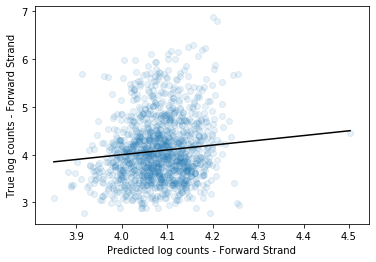

SpearmanrResult(correlation=0.1419272898028369, pvalue=3.4214926587937373e-07)


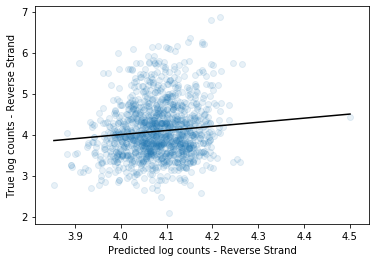

SpearmanrResult(correlation=0.123006584940508, pvalue=1.0181284794281265e-05)


In [6]:
%matplotlib inline

keras_test_batch_generator = coordbased.core.KerasBatchGenerator(
  coordsbatch_producer=coordbatchproducers.SimpleCoordsBatchProducer(
            bed_file="/users/amr1/pho4/data/a5/tseries/2hr/test_1000_around_summits.bed.gz",
            batch_size=128,
            shuffle_before_epoch=False, 
            seed=1234),
  inputs_coordstovals=inputs_coordstovals,
  targets_coordstovals=targets_coordstovals)#,qc_func=qc_func)

test_preds_logcount = []
test_seqs = []
test_preds_profile = []
test_labels_logcount = []
test_labels_profile = []
for batch_idx in range(10):#len(keras_test_batch_generator)):
    batch_inputs, batch_labels = keras_test_batch_generator[batch_idx]
    test_seqs.append(batch_inputs['sequence'])
    test_preds = model.predict(batch_inputs)
    test_preds_logcount.append(test_preds[0])
    test_preds_profile.append(test_preds[1])
    test_labels_logcount.append(batch_labels['task0_logcount'])
    test_labels_profile.append(batch_labels['task0_profile'])
test_seqs = np.concatenate(test_seqs,axis=0)
test_preds_logcount = np.concatenate(test_preds_logcount, axis=0)
test_preds_profile = np.concatenate(test_preds_profile, axis=0)
test_labels_logcount = np.concatenate(test_labels_logcount, axis=0)
test_labels_profile = np.concatenate(test_labels_profile, axis=0)

from matplotlib import pyplot as plt
from scipy.stats import spearmanr

test_labels_logtotalcount = np.log(np.sum(np.exp(test_labels_logcount) - 1,axis=-1) + 1)


#do a scatterplot of total count predictions
plt.scatter(test_preds_logcount[:,0], test_labels_logcount[:,0], alpha=0.1)
plt.xlabel("Predicted log counts - Forward Strand")
plt.ylabel("True log counts - Forward Strand")
plt.plot([np.min(test_preds_logcount[:,0]), np.max(test_preds_logcount[:,0])],
         [np.min(test_preds_logcount[:,0]), np.max(test_preds_logcount[:,0])],
         color="black")
plt.show()
print(spearmanr(test_preds_logcount[:,0], test_labels_logcount[:,0]))

plt.scatter(test_preds_logcount[:,1], test_labels_logcount[:,1], alpha=0.1)
plt.xlabel("Predicted log counts - Reverse Strand")
plt.ylabel("True log counts - Reverse Strand")
plt.plot([np.min(test_preds_logcount[:,1]), np.max(test_preds_logcount[:,1])],
         [np.min(test_preds_logcount[:,1]), np.max(test_preds_logcount[:,1])],
         color="black")
plt.show()
print(spearmanr(test_preds_logcount[:,1], test_labels_logcount[:,1]))

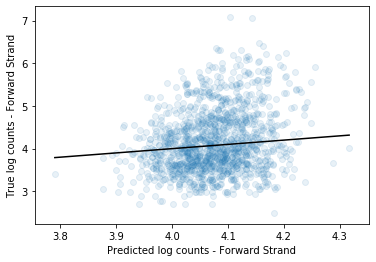

SpearmanrResult(correlation=0.20859755704379576, pvalue=4.743094048830489e-14)


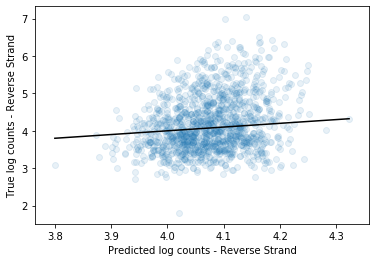

SpearmanrResult(correlation=0.2268908677072801, pvalue=2.0873548942738543e-16)


In [7]:
o_train_preds_logcount = []
o_train_seqs = []
o_train_preds_profile = []
o_train_labels_logcount = []
o_train_labels_profile = []

orig_seqs = []

for batch_idx in range(10):#len(keras_train_batch_generator)):
    batch_inputs, batch_labels = keras_train_batch_generator[batch_idx]
    o_train_seqs.append(batch_inputs['sequence'])    
    train_preds = model.predict(batch_inputs)
    o_train_preds_logcount.append(train_preds[0])
    o_train_preds_profile.append(train_preds[1])
    o_train_labels_logcount.append(batch_labels['task0_logcount'])
    o_train_labels_profile.append(batch_labels['task0_profile'])
o_train_seqs = np.concatenate(o_train_seqs,axis=0)
o_train_preds_logcount = np.concatenate(o_train_preds_logcount, axis=0)
o_train_preds_profile = np.concatenate(o_train_preds_profile, axis=0)
o_train_labels_logcount = np.concatenate(o_train_labels_logcount, axis=0)
o_train_labels_profile = np.concatenate(o_train_labels_profile, axis=0)

from matplotlib import pyplot as plt
from scipy.stats import spearmanr

o_train_labels_logtotalcount = np.log(np.sum(np.exp(o_train_labels_logcount) - 1,axis=-1) + 1)

#do a scatterplot of total count predictions
plt.scatter(o_train_preds_logcount[:,0], o_train_labels_logcount[:,0], alpha=0.1)
plt.xlabel("Predicted log counts - Forward Strand")
plt.ylabel("True log counts - Forward Strand")
plt.plot([np.min(o_train_preds_logcount[:,0]), np.max(o_train_preds_logcount[:,0])],
         [np.min(o_train_preds_logcount[:,0]), np.max(o_train_preds_logcount[:,0])],
         color="black")
plt.show()
print(spearmanr(o_train_preds_logcount[:,0], o_train_labels_logcount[:,0]))

plt.scatter(o_train_preds_logcount[:,1], o_train_labels_logcount[:,1], alpha=0.1)
plt.xlabel("Predicted log counts - Reverse Strand")
plt.ylabel("True log counts - Reverse Strand")
plt.plot([np.min(o_train_preds_logcount[:,1]), np.max(o_train_preds_logcount[:,1])],
         [np.min(o_train_preds_logcount[:,1]), np.max(o_train_preds_logcount[:,1])],
         color="black")
plt.show()
print(spearmanr(o_train_preds_logcount[:,1], o_train_labels_logcount[:,1]))